# Lab 9

In this lab, you will create and train a replica of the DeepSea model for DNA sequence prediction of e.g., transcription factor binding events.

## Background

- [DeepSea](https://www.nature.com/articles/nmeth.3547) is a convolutional neural network. The paper, as well as a review on deep learning for genomics, can be found on bCourses.
- For an overview of this class of neural networks, please watch the accompanying lab video on bCourses (which may come online a few days after release of this assignment)
- [Tensorflow basic tutorial](https://www.tensorflow.org/tutorials/quickstart/beginner)
- Stanford course notes on [convolutional neural networks](https://cs231n.github.io/convolutional-networks/)

## Submission guidelines

1. Make a copy of this notebook and save it on your own google drive (File -> Save a copy in drive)
1. Complete your version of this notebook on Google Colab
1. Share your notebook so that anyone on the internet can view with link (check via private browser to see that anyone can view)
1. Submit the link to bCourses only upon completion 
1. Download this notebook as a .py file and upload this as well.

Please remember that while you can discuss this assignment with other students, the assignment should be your own work.

Also, you can likely complete this lab without understanding neural networks in depth through pattern matching the code; however, we strongly encourage at least having a good intuition for how convolutional neural nets work.

## Name

Travis Hanly



## Imports

To build the model, we will use Tensorflow, and specifically it's Keras API.

In [ ]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import sklearn
import seaborn as sns

%pip install scikit-plot
import scikitplot as skplt

## Load data

In [ ]:
!wget https://github.com/bioe131/lab9/raw/main/deepsea10k.tar.gz
!tar -xf "deepsea10k.tar.gz"

--2021-11-10 02:18:07--  https://github.com/bioe131/lab9/raw/main/deepsea10k.tar.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bioe131/lab9/main/deepsea10k.tar.gz [following]
--2021-11-10 02:18:07--  https://raw.githubusercontent.com/bioe131/lab9/main/deepsea10k.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6036702 (5.8M) [application/octet-stream]
Saving to: ‘deepsea10k.tar.gz.2’

deepsea10k.tar.gz.2 100%[===================>]   5.76M  --.-KB/s    in 0.08s   

2021-11-10 02:18:08 (68.0 MB/s) - ‘deepsea10k.tar.gz.2’ saved [6036702/6036702]



In [ ]:
# full dataset if you're curious, very large file!
# !wget http://deepsea.princeton.edu/media/code/deepsea_train_bundle.v0.9.tar.gz

In [ ]:
def load_data(path):
    '''
    Loads DeepSEA HDF5 data and reorders the axes.
    
    Returns 
    -------
    (sequences, labels), where the first axis is sample #.
    '''
    with h5py.File(path, 'r') as f:
        sequences = f['trainxdata'][:,:,:]
        labels = f['traindata'][:, :]
    return np.rollaxis(sequences, 2).astype(np.float16), np.rollaxis(labels, 1).astype(np.float16)

## Part 1


In [ ]:
sequences, labels = load_data("train10k.mat")

Here we split the data into train and test sets. In machine learning, it's important to hold data out to understand the generalization capability of the model. For this lab we are using scikit-learn for these basic preprocessing steps.

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.25)

### 1.1 What is the shape of the data and what does each dimension represent?



The input data is 10000 x 1000 x 4 - this mean that we have 10000 sequences that are 1000 nucleotides long, and each nucleotide is encoded with one-hot encoding (4 data points for 4 nucleotides).

The labels are 10000 x 919 - 10000 sequences with 919 classification labels for the sequences.  

Note that of the 919 different labels, they are split into types:

1. DNase I-hypersensitive sites `range(0, 125)`
2. Transcription factors `range(125, 125 + 690)`
3. Histone Marks `range(125 + 690, 125 + 690 + 104)`

## Part 2

### 2.1 

**Implement and train a basic fully connected network (multilayer perceptron) by completing the SimpleDeepSea class with the following architecture:**

Model Architecture: 
1. Dense layer (2000 units, ‘relu’ activation)
2. BatchNormalization
3. Dropout layer (dropout rate 0.3)
4. Dense layer (2000 units, ‘relu’ activation)
5. BatchNormalization
6. Dropout layer (dropout rate 0.3)
7. Dense layer (919 units, ‘sigmoid’ activation)


You can complete the `SimpleDeepSEA` class, which is partially implemented below. You are encouraged to read the tf.keras docs. For example, dense layers are [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

In [ ]:
class SimpleDeepSEA(keras.Model):
    def __init__(self):
        super(SimpleDeepSEA, self).__init__()

        self.flatten = keras.layers.Flatten()
        self.dense_1 = keras.layers.Dense(
            units=2000,
            activation='relu',
        )
        self.batchnormalization_1 = keras.layers.BatchNormalization()
        self.dropout_1 = keras.layers.Dropout(.3)
        self.dense_2 = keras.layers.Dense(
            units=2000,
            activation='relu',
        )
        self.batchnormalization_2 = keras.layers.BatchNormalization()
        self.dropout_2 = keras.layers.Dropout(.3)
        self.dense_3 = keras.layers.Dense(
            units=919,
            activation='sigmoid',
        )

    def call(self, inputs, **kwargs):
        """
        Forward propagation of DeepSEA model.

        Parameters
        ----------
        inputs
            shape = (batch_size, length, c)
        kwargs

        Returns
        -------
        shape = (batch_size, 919)
        """

        temp = self.flatten(inputs)
        temp = self.dense_1(temp)
        temp = self.batchnormalization_1(temp)
        temp = self.dropout_1(temp)
        temp = self.dense_2(temp)
        temp = self.batchnormalization_2(temp)
        temp = self.dropout_2(temp)
        output = self.dense_3(temp)

        return output

In [ ]:
# Build the model.
simple_model = SimpleDeepSEA()
simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy())
simple_model.build(input_shape = (None, 1000, 4))
simple_model.summary()

Model: "simple_deep_sea_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  8002000   
                                                                 
 batch_normalization_4 (Batc  multiple                 8000      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                                 
 dense_11 (Dense)            multiple                  4002000   
                                                                 
 batch_normalization_5 (Batc  multiple                 8000      
 hNormalization)                                 

In [ ]:
# Training the model.
history = simple_model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.1,
    epochs=75,
)

Epoch 1/75
211/211 [==============================] - 4s 13ms/step - loss: 0.3301 - val_loss: 0.1137
Epoch 2/75
211/211 [==============================] - 3s 12ms/step - loss: 0.1084 - val_loss: 0.1067
Epoch 3/75
211/211 [==============================] - 2s 12ms/step - loss: 0.1014 - val_loss: 0.1091
Epoch 4/75
211/211 [==============================] - 3s 12ms/step - loss: 0.0947 - val_loss: 0.1164
Epoch 5/75
211/211 [==============================] - 2s 12ms/step - loss: 0.0880 - val_loss: 0.1146
Epoch 6/75
211/211 [==============================] - 2s 12ms/step - loss: 0.0813 - val_loss: 0.1213
Epoch 7/75
211/211 [==============================] - 2s 12ms/step - loss: 0.0771 - val_loss: 0.1223
Epoch 8/75
211/211 [==============================] - 2s 12ms/step - loss: 0.0726 - val_loss: 0.1339
Epoch 9/75
211/211 [==============================] - 2s 12ms/step - loss: 0.0673 - val_loss: 0.1521
Epoch 10/75
211/211 [==============================] - 2s 12ms/step - loss: 0.0622 - val_lo

In [ ]:
simple_predictions = simple_model.predict(X_test)

## Part 3

**Implement DeepSea by completing the DeepSea class. Below is the model architecture, which can also be found in the Supplementary Note of the DeepSea manuscript.**

Model Architecture: 
1. Convolution layer ( 320 kernels. Window size: 8. Step size: 1. ) 
2. Pooling layer ( Window size: 4. Step size: 4. ) 
3. Convolution layer ( 480 kernels. Window size: 8. Step size: 1. ) 
4. Pooling layer ( Window size: 4. Step size: 4. ) 
5. Convolution layer ( 960 kernels. Window size: 8. Step size: 1. ) 
6. Fully connected layer ( 925 neurons ) 
7. Sigmoid output layer 

Regularization Parameters: 

- Dropout proportion (proportion of outputs randomly set to 0): 
- Layer 2: 20% 
- Layer 4: 20% 
- Layer 5: 50% 
- All other layers: 0%

Also, 
- L2 regularization (5e-07)
- L1 sparsity (1e-08)
- Max kernel norm (0.9)

You can complete the `DeepSEA` class, which is partially implemented below.


In [ ]:
class DeepSEA(keras.Model):
    def __init__(self):
        
        super(DeepSEA, self).__init__()

        self.conv_1 = keras.layers.Conv1D(
            filters=320,
            kernel_size=8,
            strides=1,
            use_bias=False,
            padding='SAME',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(5e-07),
            kernel_constraint=tf.keras.constraints.MaxNorm(0.9))
        
        self.pool_1 = keras.layers.MaxPool1D(pool_size=4, 
                                                strides=4, 
                                                padding='SAME')
        
        self.dropout_1 = keras.layers.Dropout(.2)

        self.conv_2 = keras.layers.Conv1D(
            filters=480,
            kernel_size=8,
            strides=1,
            use_bias=False,
            padding='SAME',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(5e-07),
            kernel_constraint=tf.keras.constraints.MaxNorm(0.9))
        
        self.pool_2 = keras.layers.MaxPool1D(pool_size=4, 
                                                strides=4, 
                                                padding='SAME')
        
        self.dropout_2 = keras.layers.Dropout(.2)

        self.conv_3 = keras.layers.Conv1D(
            filters=960,
            kernel_size=8,
            strides=1,
            use_bias=False,
            padding='SAME',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(5e-07),
            kernel_constraint=tf.keras.constraints.MaxNorm(0.9)) 
         
        self.dropout_3 = keras.layers.Dropout(.2)

        self.flatten = keras.layers.Flatten()

        self.dense_1 = keras.layers.Dense(
            units=925,
            activation='relu',
            activity_regularizer=tf.keras.regularizers.l1(1e-08))
        
        self.dense_2 = keras.layers.Dense(
            units=919,
            activation='sigmoid',)      

    def call(self, inputs, **kwargs):
        """
        Forward propagation of DeepSEA model.

        Parameters
        ----------
        inputs
            shape = (batch_size, length, c)
        kwargs

        Returns
        -------
        shape = (batch_size, 919)
        """
        # Convolution Layer 1
        # shape = (batch_size, 1000, 320)
        temp = self.conv_1(inputs)

        # Pooling Layer 1
        # shape = (batch_size, 250, 320)
        temp = self.pool_1(temp)

        # Dropout Layer 1
        # shape = (batch_size, 250, 320)
        temp = self.dropout_1(temp)

        # Convolution Layer 2
        # shape = (batch_size, 250, 480)
        temp = self.conv_2(temp)

        # Pooling Layer 2
        # shape = (batch_size, 63, 480)
        temp = self.pool_2(temp)

        # Dropout Layer 2
        # shape = (batch_size, 63, 480)
        temp = self.dropout_2(temp)

        # Convolution Layer 3
        # shape = (batch_size, 63, 960)
        temp = self.conv_3(temp)

        # Dropout Layer 3
        # shape = (batch_size, 63, 960)
        temp = self.dropout_3(temp)

        # Flatten Layer 1
        # shape = (batch_size, 60480)
        temp = self.flatten(temp)

        # Fully Connection Layer 1
        # shape = (batch_size, 925)
        temp = self.dense_1(temp)

        # Fully Connection Layer 2
        # shape = (batch_size, 919)
        output = self.dense_2(temp)

        return output

### 3.1 What is the shape of the outputted tensor of each layer?


For this question, answer by adding comments above each layer call in the `call` method. Please also describe the method you used to answer this question below.

The shape of each layer was determined as listed below, and additionally confirmed with temporary code inside the call function:


*   **Convolution Layers:** Since the stride is 1 and the padding is set to "same", these will not alter the length of the previous layer, and all have output size of the following shape: (batch_size, length_of_previous_layer, num_kernels)
*   **Pooling Layers:** Each of these are collapsing the length of the previous layer, and will have the following shape: (batch_size, length_previous_layer / 4, num_kernels_previous_layer)
*   **Dropout Layers:** Do not change the shape of the previous layer, as they only cut connections, not nodes. 
*   **Flatten Layers:** These reduce the dimensions, and take the shape: (batch_size, length_previous_layer * num_kernels_previous_layer)
*   **Dense Layers:** These will take the shape (batch_size, number_of_neurons), with the number of neurons for the output layer being the number of labels.

In [ ]:
# Build the model.
deep_model = DeepSEA()
deep_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy())
deep_model.build(input_shape = (None, 1000, 4))
deep_model.summary()

Model: "deep_sea_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           multiple                  10240     
                                                                 
 max_pooling1d_4 (MaxPooling  multiple                 0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 conv1d_7 (Conv1D)           multiple                  1228800   
                                                                 
 max_pooling1d_5 (MaxPooling  multiple                 0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        multiple                  0

In [ ]:
# Training the model.
history = deep_model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.1,
    epochs=15,
)

Epoch 1/15
211/211 [==============================] - 25s 114ms/step - loss: 0.1130 - val_loss: 0.0943
Epoch 2/15
211/211 [==============================] - 24s 113ms/step - loss: 0.1019 - val_loss: 0.0933
Epoch 3/15
211/211 [==============================] - 24s 113ms/step - loss: 0.1010 - val_loss: 0.0910
Epoch 4/15
211/211 [==============================] - 24s 112ms/step - loss: 0.0985 - val_loss: 0.0917
Epoch 5/15
211/211 [==============================] - 24s 113ms/step - loss: 0.0953 - val_loss: 0.0892
Epoch 6/15
211/211 [==============================] - 24s 113ms/step - loss: 0.0942 - val_loss: 0.0891
Epoch 7/15
211/211 [==============================] - 24s 113ms/step - loss: 0.0925 - val_loss: 0.0887
Epoch 8/15
211/211 [==============================] - 24s 113ms/step - loss: 0.0900 - val_loss: 0.0906
Epoch 9/15
211/211 [==============================] - 24s 113ms/step - loss: 0.0847 - val_loss: 0.0865
Epoch 10/15
211/211 [==============================] - 24s 113ms/step - l

In [ ]:
def plot_loss_curve(train_loss, val_loss):
    """
    Plot the loss curve to monitor the fitting status.
    """
    plt.figure()
    plt.plot(train_loss, lw=1, label = 'Train Loss')
    plt.plot(val_loss, lw=1, label = 'Validation Loss')
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper right")


 history dict:  {'loss': [0.11298036575317383, 0.10190360248088837, 0.10102959722280502, 0.0985434278845787, 0.09534426778554916, 0.09420426189899445, 0.09245102107524872, 0.0900326818227768, 0.08470072597265244, 0.08032739907503128, 0.07743384689092636, 0.07449132949113846, 0.07156862318515778, 0.06984425336122513, 0.06849701702594757], 'val_loss': [0.09429488331079483, 0.09325014054775238, 0.0910256952047348, 0.09165681153535843, 0.08924631029367447, 0.08911003917455673, 0.088697649538517, 0.09057938307523727, 0.08652827143669128, 0.08956249058246613, 0.08604951202869415, 0.08388183265924454, 0.0829240158200264, 0.08342085033655167, 0.08173568546772003]}


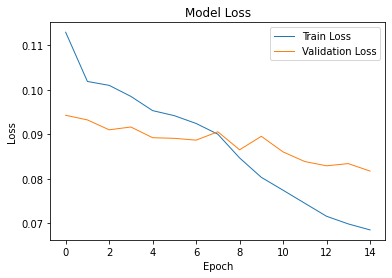

In [ ]:
# Plot the loss curve of training and validation, and save the loss value of training and validation.
print('\n history dict: ', history.history)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss_curve(train_loss, val_loss)

### 3.2 What are we looking for when inspecting a loss curve?

We want to make sure that validation loss is not going back up after intitially going down, which would indicate the onset of overfitting. 

### Get predictions

In [ ]:
deep_sea_predictions = deep_model.predict(X_test)

## Part 4

Now we'd like to evaluate how well our classifier has performed. For that we will use something called a [receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).


### 4.1 In your own words, what is an ROC curve?

The ROC curve shows the classification capability of a model at various thresholds (i.e. various probability levels for determining if an observation should be labeled as a positive or negative). The more the curve skews to the top left corner, the better the classification ability. Completely straight lines indicate no classification ability. 

### 4.2 Plot an ROC curve for each model (SimpleDeepSea, DeepSea) grouped by "label" class ('Transcription factors', 'DNase I-hypersensitive sites', 'Histone marks').

Please exclude "labels" for which there are fewer than 50 positives in the entire dataset.

**Hint: Search for `roc_curve` in scikit-learn**


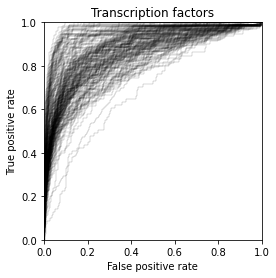

Note that of the 919 different labels, they are split into types:

1. DNase I-hypersensitive sites `range(0, 125)`
2. Transcription factors `range(125, 125 + 690)`
3. Histone Marks `range(125 + 690, 125 + 690 + 104)`

<Figure size 432x288 with 0 Axes>

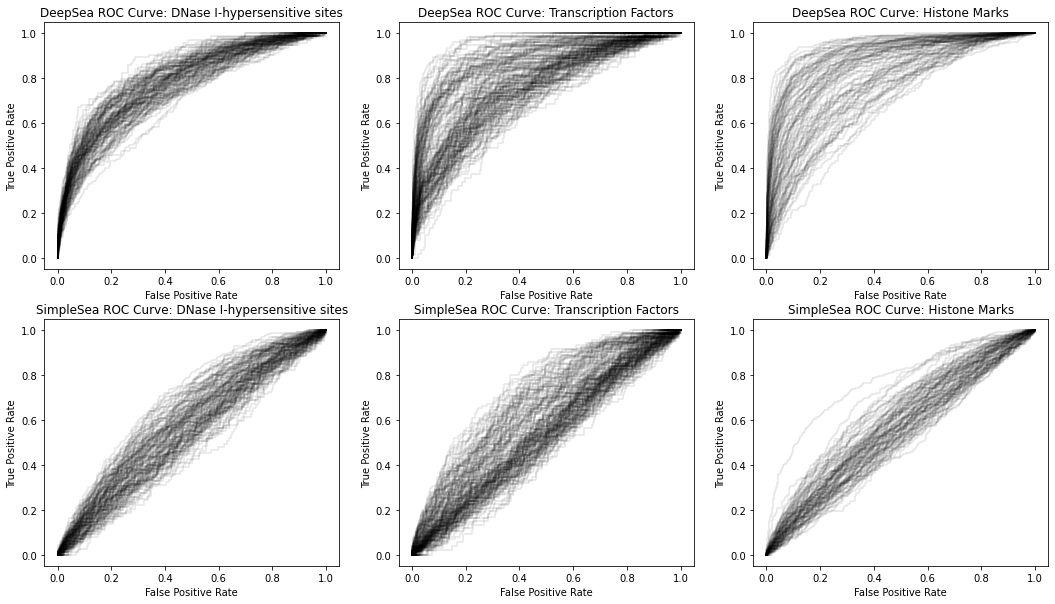

In [ ]:
##ADD AXIS LABELS##

from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

dnase_hypersensitive_sites = range(0,125)
transcription_factors = range(125, 125 + 690)
histone_marks = range(125 + 690, 125 + 690 + 104)

fig = plt.figure()
fig = plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
for i in dnase_hypersensitive_sites:
    if np.sum(y_test[:,i]) < 50: continue
    fpr, tpr, thresh = metrics.roc_curve(y_test[:,i], deep_sea_predictions[:,i])
    plt.title("DeepSea ROC Curve: DNase I-hypersensitive sites")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot(fpr,tpr, color="black", alpha=.1)

plt.subplot(2, 3, 2)
for i in transcription_factors:
    if np.sum(y_test[:,i]) < 50: continue
    fpr, tpr, thresh = metrics.roc_curve(y_test[:,i], deep_sea_predictions[:,i])
    plt.title("DeepSea ROC Curve: Transcription Factors")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot(fpr,tpr, color="black", alpha=.1)

plt.subplot(2, 3, 3)
for i in histone_marks:
    if np.sum(y_test[:,i]) < 50: continue
    fpr, tpr, thresh = metrics.roc_curve(y_test[:,i], deep_sea_predictions[:,i])
    plt.title("DeepSea ROC Curve: Histone Marks")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot(fpr,tpr, color="black", alpha=.1)

plt.subplot(2, 3, 4)
for i in dnase_hypersensitive_sites:
    if np.sum(y_test[:,i]) < 50: continue
    fpr, tpr, thresh = metrics.roc_curve(y_test[:,i], simple_predictions[:,i])
    plt.title("SimpleSea ROC Curve: DNase I-hypersensitive sites")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot(fpr,tpr, color="black", alpha=.1)

plt.subplot(2, 3, 5)
for i in transcription_factors:
    if np.sum(y_test[:,i]) < 50: continue
    fpr, tpr, thresh = metrics.roc_curve(y_test[:,i], simple_predictions[:,i])
    plt.title("SimpleSea ROC Curve: Transcription Factors")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot(fpr,tpr, color="black", alpha=.1)

plt.subplot(2, 3, 6)
for i in histone_marks:
    if np.sum(y_test[:,i]) < 50: continue
    fpr, tpr, thresh = metrics.roc_curve(y_test[:,i], simple_predictions[:,i])
    plt.title("SimpleSea ROC Curve: Histone Marks")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot(fpr,tpr, color="black", alpha=.1)

### 4.3 Make a boxplot, grouped by model, and for each "label" class, where the values are the AUROC (area under roc).

Consider making a DataFrame and using Seaborn. This should be one single plot, points will be taken off for multiple plots.

[Example plot](https://seaborn.pydata.org/_images/grouped_boxplot.png)

Relating this example to the desired plot, smoker would be model and day would be label class.

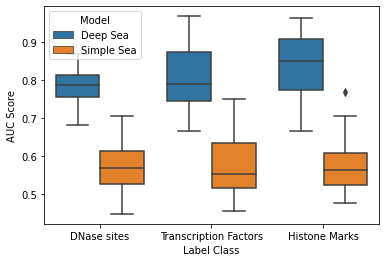

In [ ]:
roc_auc_scores = []

for i in dnase_hypersensitive_sites:
    if np.sum(y_test[:,i]) < 50: continue
    auc_score = metrics.roc_auc_score(y_test[:,i], deep_sea_predictions[:,i])
    roc_auc_scores.append([auc_score, "Deep Sea", "DNase sites"])

for i in transcription_factors:
    if np.sum(y_test[:,i]) < 50: continue
    auc_score = metrics.roc_auc_score(y_test[:,i], deep_sea_predictions[:,i])
    roc_auc_scores.append([auc_score, "Deep Sea", "Transcription Factors"])

for i in histone_marks:
    if np.sum(y_test[:,i]) < 50: continue
    fpr, tpr, thresh = metrics.roc_curve(y_test[:,i], deep_sea_predictions[:,i])
    auc_score = metrics.roc_auc_score(y_test[:,i], deep_sea_predictions[:,i])
    roc_auc_scores.append([auc_score, "Deep Sea", "Histone Marks"])

for i in dnase_hypersensitive_sites:
    if np.sum(y_test[:,i]) < 50: continue
    auc_score = metrics.roc_auc_score(y_test[:,i], simple_predictions[:,i])
    roc_auc_scores.append([auc_score, "Simple Sea", "DNase sites"])

for i in transcription_factors:
    if np.sum(y_test[:,i]) < 50: continue
    auc_score = metrics.roc_auc_score(y_test[:,i], simple_predictions[:,i])
    roc_auc_scores.append([auc_score, "Simple Sea", "Transcription Factors"])

for i in histone_marks:
    if np.sum(y_test[:,i]) < 50: continue
    auc_score = metrics.roc_auc_score(y_test[:,i], simple_predictions[:,i])
    roc_auc_scores.append([auc_score, "Simple Sea", "Histone Marks"])

roc_auc_scores_frame = pd.DataFrame(data=roc_auc_scores, 
                                    columns=["AUC Score", "Model", "Label Class"])

sns.boxplot(data=roc_auc_scores_frame, x="Label Class", y="AUC Score", hue="Model")

### 4.4 Write a paragraph commenting on the performance of the models for given "label" classes.

The simple model has a median AUC of ~0.55 for each of the label classes, meaning that it barely performs better than a random guess. This means that the simple model architecture cannot capture the nuances of the problem and/or the number of training observations was insufficient. 

The DeepSea replica model, however, performs with a median AUC just below .8 for the DNase sites and transcription factors, and around .85 for the histone marks. This indicates that the model is relatively good at discriminating between positive/negative observations. The AUC for histone marks comes very close to matching the performance in the paper, which used far more training data (median AUC = 0.856 in the paper). The other two classes likely need more training data to reach full discriminatory power, as the paper lists median AUC scores around 0.9 for both of those classes.